In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import os
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED)

# Hiperparámetros
BATCH_SIZE = 32
EMBED_DIM = 128
NUM_HEADS = 4
NUM_ENCODER_LAYERS = 2
HIDDEN_DIM = 256
DROPOUT = 0.2
MAX_LEN = 200
EPOCHS = 15

# Tokenizador
tokenizer = get_tokenizer("basic_english")

# Construir vocabulario
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

train_iter = IMDB(split='train')
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<pad>", "<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Redefinir iteradores tras consumirlos
train_iter = IMDB(split='train')
test_iter = IMDB(split='test')

# Funciones de procesamiento
def encode(text):
    return vocab(tokenizer(text))[:MAX_LEN]

def pad_sequence(seq):
    return seq + [vocab["<pad>"]] * (MAX_LEN - len(seq))

def preprocess(example):
    label, text = example

    # Decodificar si viene como bytes
    if isinstance(label, bytes):
        label = label.decode("utf-8")
    if isinstance(text, bytes):
        text = text.decode("utf-8")

    # Normalizar etiqueta a 0.0 o 1.0
    if isinstance(label, int):
        label_tensor = torch.tensor(1.0 if label == 1 else 0.0)
    elif isinstance(label, str):
        label = label.strip().lower()
        if label == "pos":
            label_tensor = torch.tensor(1.0)
        elif label == "neg":
            label_tensor = torch.tensor(0.0)
        else:
            raise ValueError(f"Etiqueta desconocida: {label}")
    else:
        raise TypeError(f"Tipo inesperado en etiqueta: {type(label)}")

    text_tensor = torch.tensor(pad_sequence(encode(text)), dtype=torch.long)
    return text_tensor, label_tensor

# Dataset personalizado
class IMDbDataset(Dataset):
    def __init__(self, data_iter):
        self.data = [preprocess(x) for x in data_iter]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Crear datasets
train_dataset = IMDbDataset(train_iter)
test_dataset = IMDbDataset(test_iter)

# Verificar distribución
print("Distribución en train:", Counter([y.item() for _, y in train_dataset]))
print("Distribución en test :", Counter([y.item() for _, y in test_dataset]))

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Distribución en train: Counter({1.0: 12500, 0.0: 12500})
Distribución en test : Counter({1.0: 12500, 0.0: 12500})


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Epoch 1/15: 100%|██████████| 782/782 [00:23<00:00, 32.96it/s] 



Epoch 1
Loss     : 373.4786
Accuracy : 0.8230
Precision: 0.8135
Recall   : 0.8382
F1-Score : 0.8256

✅ Modelo actualizado y guardado (mejor F1)



Epoch 2/15: 100%|██████████| 782/782 [00:24<00:00, 32.21it/s] 



Epoch 2
Loss     : 237.6848
Accuracy : 0.8311
Precision: 0.7987
Recall   : 0.8854
F1-Score : 0.8398

✅ Modelo actualizado y guardado (mejor F1)



Epoch 3/15: 100%|██████████| 782/782 [00:24<00:00, 32.04it/s] 



Epoch 3
Loss     : 167.3830
Accuracy : 0.8342
Precision: 0.8454
Recall   : 0.8179
F1-Score : 0.8315



Epoch 4/15: 100%|██████████| 782/782 [00:23<00:00, 32.63it/s] 



Epoch 4
Loss     : 115.7643
Accuracy : 0.8258
Precision: 0.7973
Recall   : 0.8739
F1-Score : 0.8338



Epoch 5/15: 100%|██████████| 782/782 [00:25<00:00, 31.06it/s] 



Epoch 5
Loss     : 80.6062
Accuracy : 0.8187
Precision: 0.8115
Recall   : 0.8302
F1-Score : 0.8207

⏹️ Early stopping activado. No hubo mejora en F1 durante 3 épocas.



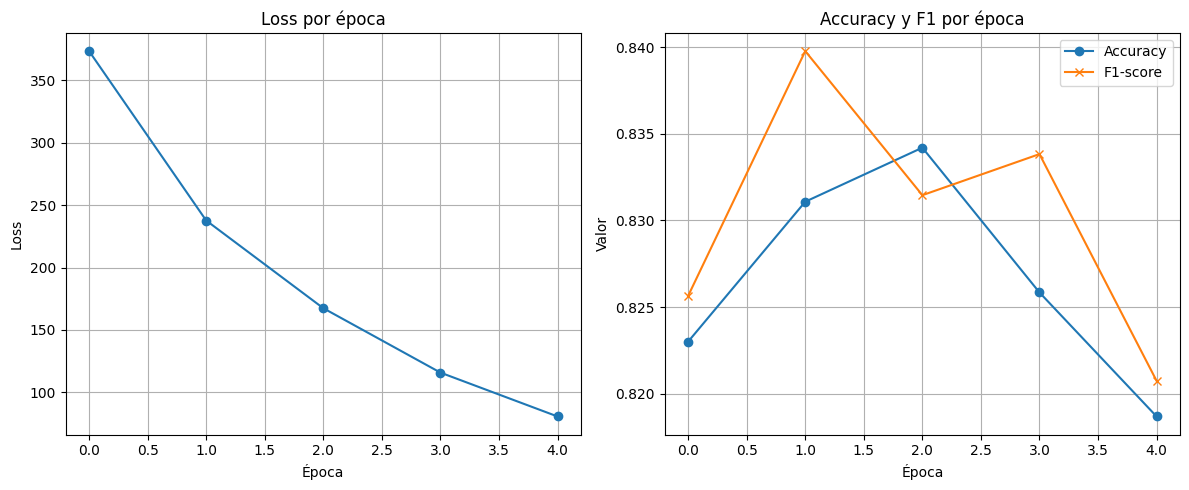

In [2]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

class SentimentTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        emb = self.embedding(x)
        emb = emb.permute(1, 0, 2)
        out = self.transformer_encoder(emb)
        out = out.mean(dim=0)
        out = self.dropout(out)
        return torch.sigmoid(self.fc(out)).view(-1)  # <- Evita errores con BCELoss

model = SentimentTransformer(
    vocab_size=len(vocab),
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_ENCODER_LAYERS,
    dropout=DROPOUT
).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def evaluate(model, dataloader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device).float().view(-1)
            outputs = model(x).view(-1)
            preds += (outputs > 0.5).int().cpu().tolist()
            targets += y.cpu().int().tolist()
    return {
        "accuracy": accuracy_score(targets, preds),
        "precision": precision_score(targets, preds, zero_division=0),
        "recall": recall_score(targets, preds, zero_division=0),
        "f1": f1_score(targets, preds, zero_division=0)
    }

# Entrenamiento con seguimiento
historial_loss = []
historial_accuracy = []
historial_f1 = []
mejor_f1 = 0.0
espera = 0
patience = 3

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x = x.to(device)
        y = y.to(device).float().view(-1)
        optimizer.zero_grad()
        outputs = model(x).view(-1)

        # Debug temporal (eliminar después)
        if torch.any((outputs < 0) | (outputs > 1)):
            print("⚠️ Warning: Outputs fuera de rango:", outputs)
        if torch.any((y != 0) & (y != 1)):
            print("⚠️ Warning: Targets inválidos:", y)

        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    eval_result = evaluate(model, test_loader)
    historial_loss.append(total_loss)
    historial_accuracy.append(eval_result["accuracy"])
    historial_f1.append(eval_result["f1"])

    print(f"\nEpoch {epoch+1}")
    print(f"Loss     : {total_loss:.4f}")
    print(f"Accuracy : {eval_result['accuracy']:.4f}")
    print(f"Precision: {eval_result['precision']:.4f}")
    print(f"Recall   : {eval_result['recall']:.4f}")
    print(f"F1-Score : {eval_result['f1']:.4f}\n")

    if eval_result["f1"] > mejor_f1:
        mejor_f1 = eval_result["f1"]
        espera = 0
        torch.save(model.state_dict(), "../modelos/modelo_sentimiento.pth")
        print("✅ Modelo actualizado y guardado (mejor F1)\n")
    else:
        espera += 1
        if espera >= patience:
            print(f"⏹️ Early stopping activado. No hubo mejora en F1 durante {patience} épocas.\n")
            break

# Gráficos de evolución
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(historial_loss, marker='o', label='Loss')
plt.title("Loss por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(historial_accuracy, marker='o', label='Accuracy')
plt.plot(historial_f1, marker='x', label='F1-score')
plt.title("Accuracy y F1 por época")
plt.xlabel("Época")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [3]:
from collections import Counter
print("Train:", Counter([y.item() for _, y in train_dataset]))
print("Test :", Counter([y.item() for _, y in test_dataset]))

Train: Counter({1.0: 12500, 0.0: 12500})
Test : Counter({1.0: 12500, 0.0: 12500})


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import IMDB
import ipywidgets as widgets
from IPython.display import display

# === Configuración ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 200
ruta_modelo = "../modelos/modelo_sentimiento.pth"

# === Tokenizador y vocabulario ===
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(IMDB(split='train')), specials=["<pad>", "<unk>"])
vocab.set_default_index(vocab["<unk>"])

def encode(text):
    return vocab(tokenizer(text))[:MAX_LEN]

def pad_sequence(seq):
    return seq + [vocab["<pad>"]] * (MAX_LEN - len(seq))

# === Modelo ===
class SentimentTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,  # 👈 Coincide con el entrenamiento
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x):
        emb = self.embedding(x)
        out = self.transformer_encoder(emb)
        out = out.mean(dim=1)
        return torch.sigmoid(self.fc(out)).squeeze(1)

# === Cargar modelo ===
model = SentimentTransformer(
    vocab_size=len(vocab),
    embed_dim=128,
    num_heads=4,
    hidden_dim=256,  # 👈 debe coincidir
    num_layers=2,
    dropout=0.2
).to(device)

model.load_state_dict(torch.load(ruta_modelo, map_location=device))
model.eval()

# === Widgets ===
caja_texto = widgets.Textarea(
    value='',
    placeholder='Escribe una reseña en inglés...',
    description='Reseña:',
    layout=widgets.Layout(width='100%', height='100px')
)

boton = widgets.Button(description="Predecir sentimiento", button_style='info')
salida = widgets.Output()

def on_click(b):
    with salida:
        salida.clear_output()
        texto = caja_texto.value
        ids = pad_sequence(encode(texto))
        input_tensor = torch.tensor([ids], dtype=torch.long).to(device)
        with torch.no_grad():
            salida_modelo = model(input_tensor)
            prob = salida_modelo.item()
            clase = "Negativo" if prob >= 0.5 else "Positivo"
            print(f"Predicción: {clase} (confianza: {round(prob, 3)})")

boton.on_click(on_click)

# === Mostrar interfaz ===
display(caja_texto, boton, salida)


Textarea(value='', description='Reseña:', layout=Layout(height='100px', width='100%'), placeholder='Escribe un…

Button(button_style='info', description='Predecir sentimiento', style=ButtonStyle())

Output()